# Lesson 6: pets revisited

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [2]:
bs = 64

In [3]:
path = untar_data(URLs.PETS)/'images'

## Data augmentation

In [4]:
tfms = get_transforms(max_rotate=20,
                      max_zoom=1.3, 
                      max_lighting=0.4, 
                      max_warp=0.4,
                      p_affine=1., # set probability of affine transformation to 100%
                      p_lighting=1.) # set 100% too

In [5]:
#doc(get_transforms)

In [6]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [7]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [8]:
data = get_data(224, bs, 'zeros') # we using zeroes (black) padding

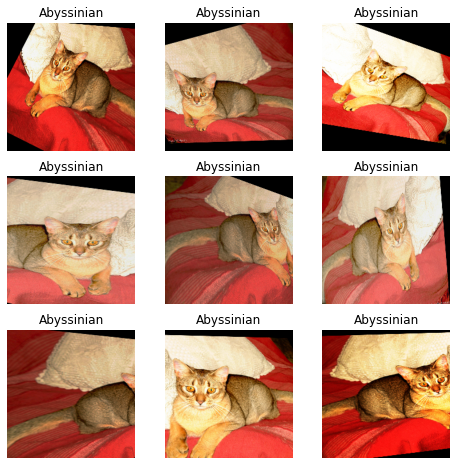

In [9]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [10]:
data = get_data(224,bs) # we using reflection padding. This is more often better suited.

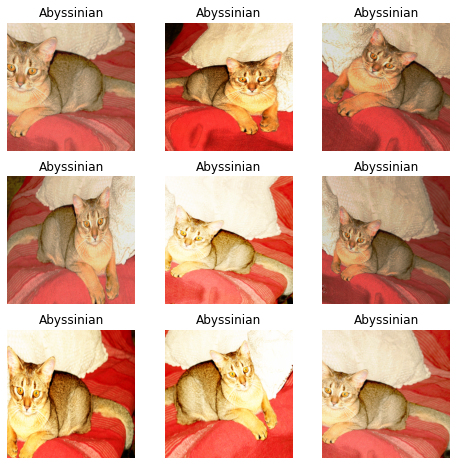

In [11]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model (first of size 224, then 352)

In [12]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

In [ ]:
learn.fit_one_cycle(3, 
                    slice(1e-2), 
                    pct_start=0.8) # default value is 0.3. Refers to proportion of batches within each epoch where lr is rising.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

In [ ]:
learn.save('224')

In [13]:
bs = 24
learn.load('224')
data = get_data(352,bs) # We obtain a new databunch of larger size, to further train our model for better results.
learn.data = data

TY - How come you can just increase the data size (from `224` to `352`) and train on top of it, without changing the model or anything? Wouldn't a differing input layer meant that it couldn't "fit" into the model?

Well, it still works. This is because the total number of parameters stayed the same. Consider the arguments to the `conv` layer: The input (no. of) channels, the output (no. of) channels, stride, padding, etc. There's no mention of input height and width. Those are variables that the `conv` layer will take into account and return the appropriate sizes.

What about the `batchnorm` layer? The main argument it takes in is the number of channels. Which is once again independent of input width and size.

Note: I am just talking about computer vision only, not tabular, or collab filtering. To vary the sizes of those inputs in the latter two use cases is ambiguous, unlike increasing image size.

In [14]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.792866,0.251511,0.055480,03:35
1,0.784937,0.249976,0.058187,03:30


In [15]:
learn.save('352')

## Convolution kernel

In [16]:
data = get_data(352,16) # size = 352, bs = 16

In [17]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category 13

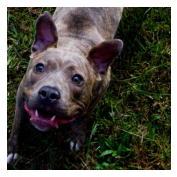

In [18]:
idx=0
x,y = data.valid_ds[idx] # idx = 0, i.e. first image in valid dataset
x.show()
data.valid_ds.y[idx]

In [21]:
# k is kernel

k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

# create a 1x3x3x3 kernel cube

Eyeballing the numbers in the 3x3 matrix, we can see that the attention is focused on the bottom and right edges of the kernel, and a deemphasis on the rest. 

`.expand()` simply expands the dimensions of our 3x3 tensor. Firstly, expand the 3x3 kernel to 3x3x3 cube because we are dealing with 3-channel image. For this purpose, our bottom-right edge detector is colour-agnostic, so we just copy the values two more times. 

Then, the 3x3x3 kernel is transformed to a 1x3x3x3 tensor - i.e. a rank 4 tensor. The 0th axis, with the value of `1`, describes the number of distinct kernels that we are employing for the convolution layer. In this case, we are only creating 1 kernel, so that's why the 0th axis is a value of `1`.

Note that in PyTorch, the order of axes are `no. of objects` x `channel depth` x `height` x `width`.

In [22]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [23]:
k.shape

torch.Size([1, 3, 3, 3])

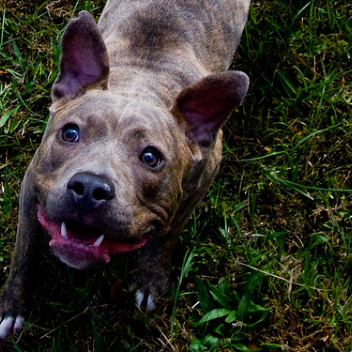

In [25]:
data.valid_ds[0][0]

In [24]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

In [26]:
t[None].shape

torch.Size([1, 3, 352, 352])

Note that in PyTorch, the order of axes are `no. of objects` x `channel depth` x `height` x `width`.

The reason why we introduced a 4th axis (making the tensor a rank 4) is because `conv2d` expects that for its input. Similarly, `conv2d` expects the kernel to be rank 4 too. 

Back to our image input: `conv2d` expects to work on batches of inputs (images) at a time, so the newly introduced axis (0-th axis) describes the number of images in the batch. In this case, the size of our mini-batch is 1.


In [27]:
edge = F.conv2d(t[None], k) # Feed in kernel from earlier

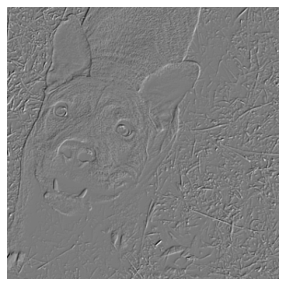

In [28]:
show_image(edge[0], figsize=(5,5));

In [29]:
data.c

37

The number of classes is 37. There're 37 different kinds of dog and cat breeds. The final layer will be 37 big - or 37 probabilities.

In [30]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [31]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

```
Sequential
======================================================================
Layer (type)         Output Shape         Param #    Trainable 
======================================================================
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
```

Our image is `[3,352,352]`.

To find out about the properties of each of the layers, scroll up the cell about `learn.model`.

- First `Conv2d` layer has stride of 2, so output width and height will be `352/2=176` (there's padding so is nicely half). Since no. of kernels is `64`, output shape is `[64, 176, 176]`.  No. of parameters is no. of kernels * kernel size * number of channels = `64 * (7*7) * 3 = 9408`.

- `BatchNorm2d` does not change output size (simply put it normalises all the activations by looking at its collective mean and sd). Also, there's the rescale aspect of it, which introduces 2 parameters per 'slice', which there are 64 of them, to generate `128`.

- `ReLU` is an activation function and does not change shape (it merely rectifies each activation at a time if need be), nor introduce parameters.

- `MaxPool2d` reduces the resolution of images by returning the maximum pixel value in each grid (`[3,3]` in this case). Since stride is 2, plus padding, so width and height of output shape is halved. Channel depth remains the same -> output shape is `[64, 88, 88]`.


0th Basic Block:
```
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True       
```
- `Conv2d` is stride = `1`, kernel size of `[3,3]`, no. of kernels = `64`, with padding. Input shape was `[64, 88, 88]`. We can deduce that output width and height will remain the same as stride is `1` (with padding). Number of channels = no. of kernels = `64`, so output space is `[64, 88, 88]`. No. of parameters is no. of kernels * kernel size * no. of channels = `64 * (3*3) * 64 = 36,864`.

- The following `Conv2d` has the exact same properties. So nothing changes.

- This concludes the 0'th Basic Block. Two more will follow. They are exactly the same.


# Heatmap

In [32]:
m = learn.model.eval();

In [33]:
xb,_ = data.one_item(x) 
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [34]:
from fastai.callbacks.hooks import *

In [35]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

This is a bit abstract, and you might have to accept at face value the following points:
- The first part of the model (resnet) is the convolutional part. This is called m[0]. 
- At the end of m[0] we get a rank 3 tensor of shape (512,11,11), in this example. 
- The next part of the model is to convert this (512,11,11) into a vector that is 37 long. 37 being the number of classes, or possible categories.
- Rank 3 to Rank 1 tensor definitely involves collapsing of dimensions, and this can be done (and is, in this case) by average pooling.
- Average pooling can be done in a variety of ways, along whatever axis or stuff. To generate the heatmap, we need to perform one particular variant of average pooling. This means we have to extract the (512,11,11) tensor first.
- We need a hook to do that.

A hook is a really cool, more advanced PyTorch feature that lets you (as the name suggests) hook into the PyTorch machinery itself, and run any arbitrary Python code you want to. It's a really amazing and nifty thing. Because normally when we do a forward pass through a PyTorch module, it gives us this set of outputs. But we know that in the process, it's calculated these (512 by 11 by 11 features). So what I would like to do is I would like to hook into that forward pass and tell PyTorch "hey, when you calculate this, can you store it for me please." 

In [36]:
hook_a,hook_g = hooked_backward()

In [37]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [42]:
avg_acts = acts.mean(0) # Take the mean across axis 0, to get average activations
avg_acts.shape # Notice how the size is (512,11,11) -> (11,11)

torch.Size([11, 11])

In [39]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

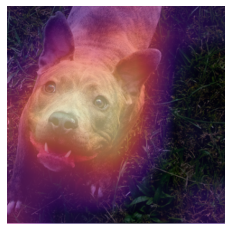

In [40]:
show_heatmap(avg_acts)

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [ ]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

In [ ]:
mult = (acts*grad_chan[...,None,None]).mean(0)

In [ ]:
show_heatmap(mult)

In [ ]:
fn = path/'../other/bulldog_maine.jpg' #Replace with your own image

In [ ]:
x = open_image(fn); x

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

In [ ]:
show_heatmap(mult)

In [ ]:
data.classes[0]

In [ ]:
hook_a,hook_g = hooked_backward(0)

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

In [ ]:
show_heatmap(mult)

## fin